In [4]:
pip install seaborn

  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [11]:
import matplotlib.pyplot as plt # side-stepping mpl backend
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_score


In [12]:
import os
for dirname, _, filenames in os.walk("..\Week3 - CyberSecurity\Homework - Week3"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-12-89b6a81e92ec>, line 2)

In [13]:
def create_col_name(base_str, start_int, end_int):
    return [base_str + str(i) for i in range(start_int, end_int+1)]

cat_cols = (['ProductCD'] + create_col_name('card', 1, 6) + ['addr1', 'addr2', 'P_emaildomain', 'R_emaildomain'] + 
            create_col_name('M', 1, 9) + ['DeviceType', 'DeviceInfo'] + create_col_name('id_', 12, 38))

id_cols = ['TransactionID', 'TransactionDT']

target = 'isFraud'

print('Categorical Columns:', cat_cols)
print('ID Columns:', id_cols)

Categorical Columns: ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
ID Columns: ['TransactionID', 'TransactionDT']


In [14]:
#Creating Dataframes
dataframe_identity_train = pd.read_csv('./train_identity.csv')
dataframe_transaction_train = pd.read_csv('../ieee-fraud-detection/train_transaction.csv')
dataframe_transaction_test = pd.read_csv('../ieee-fraud-detection/test_transaction.csv')
dataframe_identity_test = pd.read_csv('../ieee-fraud-detection/test_identity.csv')

In [15]:
print('Identity shape:',dataframe_identity_train.shape)
print('Transaction shape:',dataframe_transaction_train.shape)
print('Test Identity shape:',dataframe_identity_test.shape)
print('Test Transaction shape:',dataframe_transaction_test.shape)

Identity shape: (144233, 41)
Transaction shape: (590540, 394)
Test Identity shape: (141907, 41)
Test Transaction shape: (506691, 393)


In [16]:
df_train = dataframe_transaction_train.merge(dataframe_identity_train, on='TransactionID', how='left')
print('df_train Shape:', df_train.shape)

df_train Shape: (590540, 434)


In [17]:
df_test = dataframe_transaction_test.merge(dataframe_identity_test, on='TransactionID', how='left')
print('df_test Shape:', df_test.shape)

df_test Shape: (506691, 433)


In [18]:
del dataframe_transaction_train, dataframe_identity_train
del dataframe_transaction_test, dataframe_identity_test

Text(0, 0.5, 'Frequency')

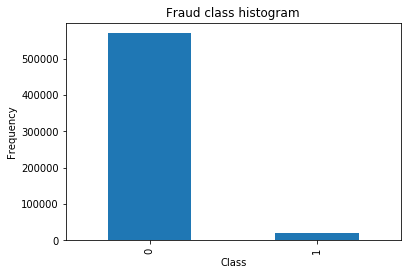

In [19]:
count_classes = pd.value_counts(df_train['isFraud'], sort = True).sort_index()
count_classes.plot(kind = 'BAR')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

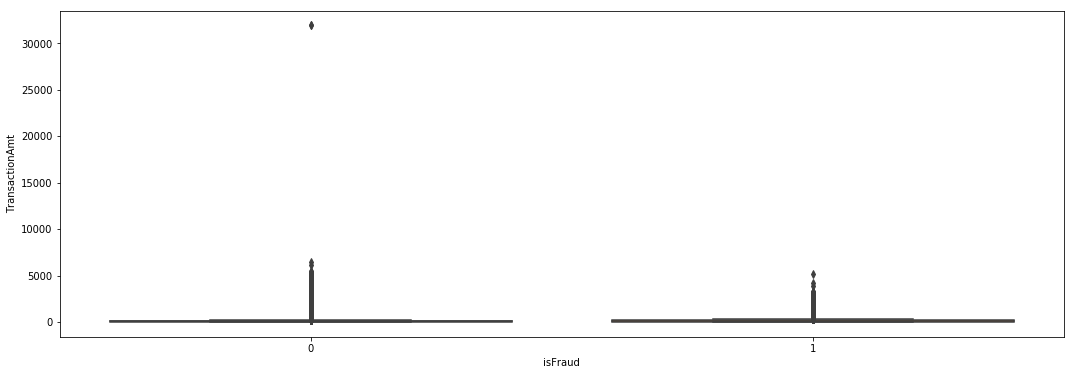

In [20]:
fig = plt.figure(figsize=(18, 6), facecolor='w')
sns.boxplot(x='isFraud', y='TransactionAmt', data=df_train)
plt.show()

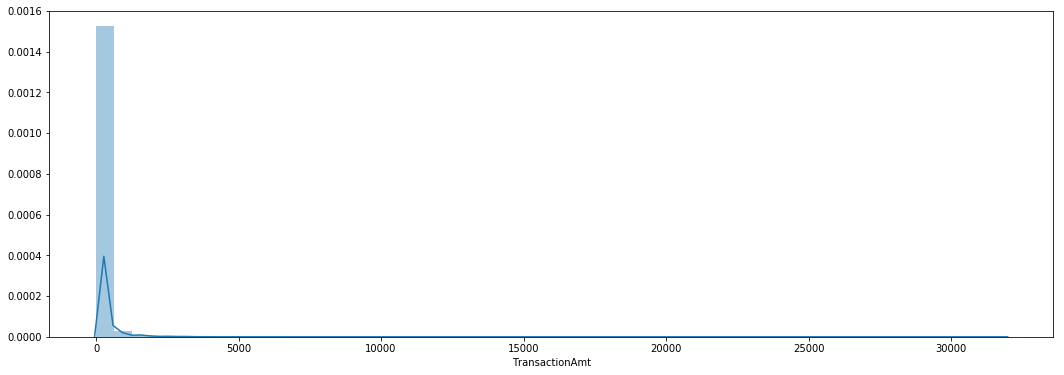

In [21]:
fig = plt.figure(figsize=(18, 6), facecolor='w')
sns.distplot(df_train['TransactionAmt'])
plt.show()

In [22]:
def plot_hist(train, colname):
    _train_0 = train[train['isFraud'] == 0].reset_index(drop=False)
    _train_1 = train[train['isFraud'] == 1].reset_index(drop=False)
    
    fig = plt.figure(figsize=(12, 4), facecolor='w')
    ax = sns.kdeplot(_train_0[colname], color='b', alpha=0.4, shade=True)
    ax_2 = ax.twinx()
    sns.kdeplot(_train_1[colname], color='r', alpha=0.4, shade=True, ax=ax_2)
    ax.set_title(colname)
    plt.show()

   

In [24]:
# source https://www.kaggle.com/krishonaveen/xtreme-boost-and-feature-engineering
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [25]:
df_train = reduce_mem_usage(df_train,True)

Mem. usage decreased to 670.48 Mb (66.1% reduction)


In [26]:
import gc

gc.collect()

2590

In [27]:
many_null_cols = [col for col in df_train.columns if df_train[col].isnull().sum() / df_train.shape[0] > 0.90]
print(many_null_cols)

['dist2', 'D7', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [28]:
print('Shape before drop:', df_train.shape)
df_train = df_train.drop(many_null_cols, axis = 1)
print('Shape after drop:',df_train.shape)

big_top_value_cols = [col for col in df_train.columns if df_train[col].value_counts(dropna=False, normalize=True).values[0] > 0.88]
big_top_value_cols.remove('isFraud')
df_train = df_train.drop(big_top_value_cols, axis = 1)
print(big_top_value_cols)

Shape before drop: (590540, 434)
Shape after drop: (590540, 422)
['card3', 'addr2', 'C3', 'C7', 'D12', 'D13', 'D14', 'V98', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V281', 'V284', 'V286', 'V290', 'V292', 'V293', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V305', 'V309', 'V311', 'V316', 'V318', 'V319', 'V320', 'V321', 'id_03', 'id_04']


In [29]:
df_test = df_test.drop(many_null_cols, axis = 1)
df_test = df_test.drop(big_top_value_cols, axis = 1)

In [30]:
from sklearn  import preprocessing
for col in df_train.columns:
    if df_train[col].dtype=='object' :
        print("label encoding",col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[col].values))
        df_train[col] =lbl.transform(list(df_train[col].values))

label encoding ProductCD
label encoding card4
label encoding card6
label encoding P_emaildomain
label encoding R_emaildomain
label encoding M1
label encoding M2
label encoding M3
label encoding M4
label encoding M5
label encoding M6
label encoding M7
label encoding M8
label encoding M9
label encoding id_12
label encoding id_15
label encoding id_16
label encoding id_28
label encoding id_29
label encoding id_30
label encoding id_31
label encoding id_33
label encoding id_34
label encoding id_35
label encoding id_36
label encoding id_37
label encoding id_38
label encoding DeviceType
label encoding DeviceInfo


In [32]:
from sklearn  import preprocessing
for col in df_test.columns:
    if df_test[col].dtype=='object' :
        print("label encoding",col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_test[col].values))
        df_test[col] =lbl.transform(list(df_test[col].values))


label encoding ProductCD
label encoding card4
label encoding card6
label encoding P_emaildomain
label encoding R_emaildomain
label encoding M1
label encoding M2
label encoding M3
label encoding M4
label encoding M5
label encoding M6
label encoding M7
label encoding M8
label encoding M9
label encoding id_12
label encoding id_15
label encoding id_16
label encoding id_28
label encoding id_29
label encoding id_30
label encoding id_31
label encoding id_33
label encoding id_34
label encoding id_35
label encoding id_36
label encoding id_37
label encoding id_38
label encoding DeviceType
label encoding DeviceInfo


In [33]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
df_train = clean_inf_nan(df_train)
df_test = clean_inf_nan(df_test) # replace all nan,inf,-inf to nan so it will be easy to replace

for i in df_train.columns:
    df_train[i].fillna(df_train[i].median(),inplace=True) # fill with median because mean may be affect by outliers.
for i in df_test.columns:
    df_test[i].fillna(df_test[i].median(),inplace=True)

In [34]:
# now we can split the data and train our model
X = df_train.drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = df_train['isFraud']
#X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = df_test.drop(['TransactionDT', 'TransactionID'], axis=1)
#del train
test = df_test[['TransactionID']]


In [35]:
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.15, random_state = 0)

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(xTrain)
xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

C:\Users\mattv\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float16, float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [37]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight={0:0.85})
model.fit(xTrain, yTrain)

LogisticRegression(C=1.0, class_weight={0: 0.85}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [38]:
from sklearn.metrics import classification_report

y_pred = model.predict(xTest)
  
print(classification_report(yTest, y_pred))

print('Logistic Score:', model.score(xTest,yTest))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     85551
           1       0.82      0.22      0.35      3030

   micro avg       0.97      0.97      0.97     88581
   macro avg       0.90      0.61      0.67     88581
weighted avg       0.97      0.97      0.96     88581

Logistic Score: 0.9717207979137739


In [39]:
import csv

scaler.fit(X_test)
X_test = scaler.transform(X_test)

y_sub_predict = model.predict_proba(X_test)

csv_data = [['TransactionID', 'isFraud']]

fraud_dict = { 'fraud': 1, 'not_fraud': 0 }

for i in range(0, len(y_sub_predict)):
    csv_data.append([df_test['TransactionID'][i], y_sub_predict[i][1]])
    if y_sub_predict[i][1] >= 0.5:
        fraud_dict['fraud'] += 1
    else:
        fraud_dict['not_fraud'] += 1
print(fraud_dict)

C:\Users\mattv\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


{'fraud': 7967, 'not_fraud': 498725}


In [40]:
with open('submission.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(csv_data)

csv_file.close()